In [20]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
import torch.nn as nn

%matplotlib inline

class BindingDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            'esm_embedding': torch.tensor(item['esm_embedding'], dtype=torch.float32),
            'smiles_embedding': torch.tensor(item['smiles_embedding'], dtype=torch.float32),
            'affinity': torch.tensor(item['affinity'], dtype=torch.float32)
        }
class AffinityDataSplitter:
    def __init__(self, dataset, val_size=0.15, random_state=42):
        self.dataset = dataset
        self.val_size = val_size
        self.random_state = random_state
        
    def calculate_affinity_bins(self, n_bins=10):
        """Create balanced bins based on affinity distribution"""
        affinities = np.array(self.dataset['affinity'])
        return pd.qcut(affinities, q=n_bins, labels=False)
    
    def stratified_split(self):
        """Perform stratified split considering affinity distribution"""
        # Get affinity bins for stratification
        affinity_bins = self.calculate_affinity_bins()
        
        # Perform stratified split
        train_idx, val_idx = train_test_split(
            np.arange(len(self.dataset)),
            test_size=self.val_size,
            stratify=affinity_bins,
            random_state=self.random_state
        )
        
        train_dataset = self.dataset.select(train_idx.tolist())
        val_dataset = self.dataset.select(val_idx.tolist())
        
        # Verify distribution
        self._verify_split_distribution(train_dataset, val_dataset)
        
        return train_dataset, val_dataset
    
    def _verify_split_distribution(self, train, val):
        """Verify that the splits maintain similar distributions"""
        print("Distribution Statistics:")
        
        # Affinity distribution - convert to numpy arrays first
        train_affinities = np.array(list(train['affinity']))
        val_affinities = np.array(list(val['affinity']))
        
        print("\nAffinity Distribution:")
        print(f"Train: mean={np.mean(train_affinities):.2f}, std={np.std(train_affinities):.2f}")
        print(f"Val:   mean={np.mean(val_affinities):.2f}, std={np.std(val_affinities):.2f}")
        
        # Sequence length distribution
        print("\nSequence Length Distribution:")
        train_lengths = [len(seq) for seq in train['sequence']]
        val_lengths = [len(seq) for seq in val['sequence']]
        
        print(f"Train: mean={np.mean(train_lengths):.1f}, std={np.std(train_lengths):.1f}")
        print(f"Val:   mean={np.mean(val_lengths):.1f}, std={np.std(val_lengths):.1f}")


In [21]:
from datasets import load_from_disk
dataset = load_from_disk('/scratch/pranamlab/sophtang/home/scoring/data/binding')
splitter = AffinityDataSplitter(
    dataset=dataset,
    val_size=0.2,
    random_state=42
)

# Perform the split
train_dataset, val_dataset = splitter.stratified_split()

# Create DataLoader for each split
train_loader = DataLoader(BindingDataset(train_dataset), batch_size=32, shuffle=True)
val_loader = DataLoader(BindingDataset(val_dataset), batch_size=32)

Distribution Statistics:

Affinity Distribution:
Train: mean=5.97, std=1.57
Val:   mean=5.96, std=1.54

Sequence Length Distribution:
Train: mean=232.9, std=154.8
Val:   mean=218.4, std=132.4


Affinity Statistics:
Min: 2.04
Max: 13.77
Mean: 5.97
Median: 5.76

Unique affinity measures: Counter({'Kd=5uM': 14, 'Kd=1.5uM': 12, 'Kd=10uM': 12, 'Kd=1.9uM': 12, 'Kd=1.8uM': 12, 'Kd=1.3uM': 10, 'Kd=15uM': 10, 'Kd=2.2uM': 10, 'Kd=8uM': 9, 'Kd=0.3uM': 9, 'Kd=1.1uM': 9, 'Kd=0.7uM': 9, 'Kd=0.2uM': 8, 'Kd=1.4uM': 8, 'Kd=20uM': 8, 'Kd=1.2uM': 8, 'Kd=3.7uM': 8, 'Kd=0.5uM': 7, 'Kd=0.32uM': 7, 'Kd=29.6uM': 7, 'Kd=0.55uM': 7, 'IC50>500uM': 7, 'Kd=10nM': 6, 'Kd=0.4uM': 6, 'Kd=0.27uM': 6, 'Kd=40uM': 6, 'Kd=1uM': 6, 'Kd=3.4uM': 6, 'Kd=5.2uM': 6, 'Kd=22uM': 6, 'Kd=7uM': 6, 'Kd=100uM': 6, 'Kd=2.3uM': 5, 'Kd=2.7uM': 5, 'Kd=12nM': 5, 'Kd=20nM': 5, 'Kd=50uM': 5, 'Kd=40nM': 5, 'Kd=2.9uM': 5, 'Kd=2.4uM': 5, 'Kd=1.6uM': 5, 'Kd=0.54uM': 5, 'Kd=2.0uM': 5, 'Kd=29uM': 5, 'Kd=1.7uM': 5, 'Kd=11uM': 5, 'Kd=0.8uM': 5, 'Kd=0.1uM': 5, 'Kd=6uM': 5, 'Kd=70uM': 5, 'Kd=17uM': 5, 'Kd=13uM': 4, 'Kd=2nM': 4, 'Kd=13nM': 4, 'Kd=23uM': 4, 'Kd=150nM': 4, 'Kd=0.34uM': 4, 'Kd=2.3nM': 4, 'Kd=5.8uM': 4, 'Kd=7.5uM': 4, 'Kd=0.18uM'

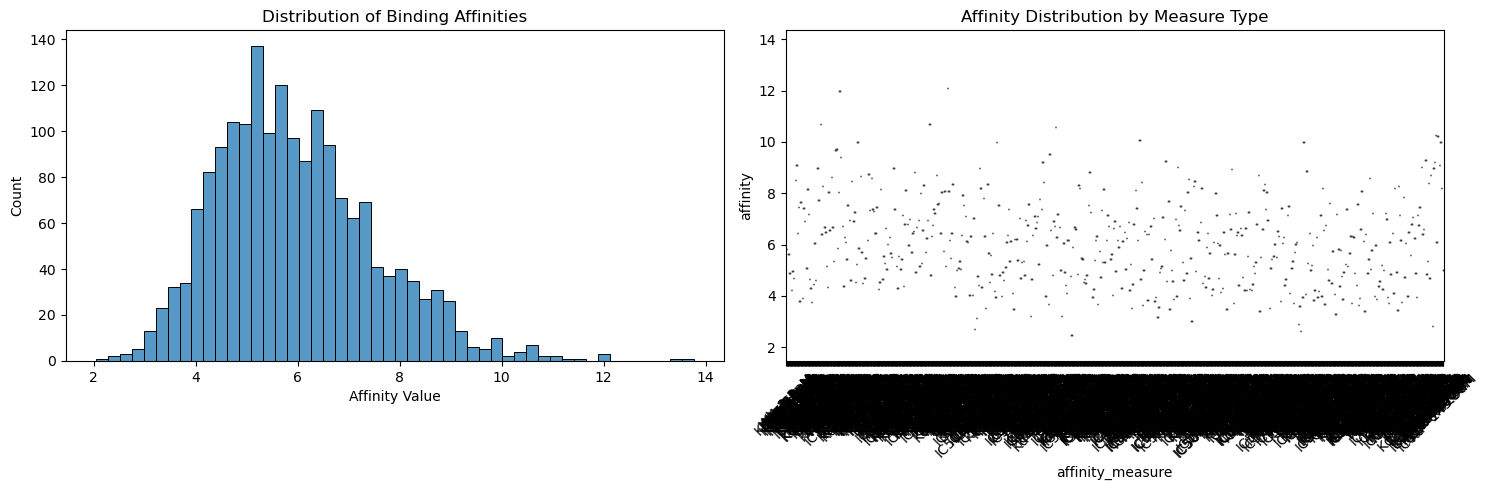

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def analyze_binding_affinities(dataset):
    """Analyze binding affinities and their measures to determine appropriate thresholds"""
    
    affinities = np.array(dataset['affinity'])
    measures = dataset['affinity_measure']
    
    # Print basic statistics
    print("Affinity Statistics:")
    print(f"Min: {affinities.min():.2f}")
    print(f"Max: {affinities.max():.2f}")
    print(f"Mean: {affinities.mean():.2f}")
    print(f"Median: {np.median(affinities):.2f}")
    print(f"\nUnique affinity measures: {Counter(measures)}")
    
    # Plot distribution
    plt.figure(figsize=(15, 5))
    
    # Overall distribution
    plt.subplot(1, 2, 1)
    sns.histplot(affinities, bins=50)
    plt.title('Distribution of Binding Affinities')
    plt.xlabel('Affinity Value')
    plt.ylabel('Count')
    
    # Box plot by measure type
    plt.subplot(1, 2, 2)
    sns.boxplot(x='affinity_measure', y='affinity', data={'affinity_measure': measures, 'affinity': affinities})
    plt.title('Affinity Distribution by Measure Type')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate measure-specific statistics
    measure_stats = {}
    for measure in set(measures):
        mask = np.array(measures) == measure
        measure_affinities = affinities[mask]
        measure_stats[measure] = {
            'count': len(measure_affinities),
            'mean': measure_affinities.mean(),
            'std': measure_affinities.std(),
            'median': np.median(measure_affinities),
            'q25': np.percentile(measure_affinities, 25),
            'q75': np.percentile(measure_affinities, 75)
        }
    
    return measure_stats

measure_stats = analyze_binding_affinities(dataset)

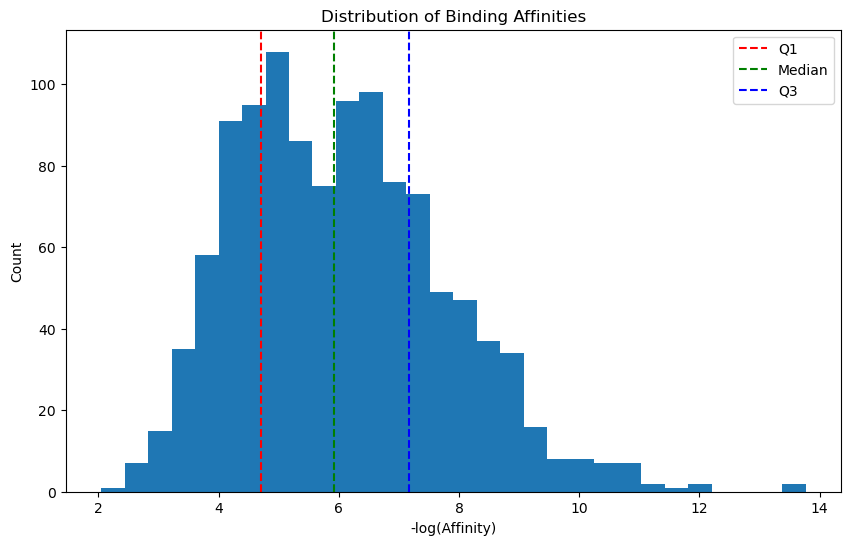

Min: 2.04
Q1: 4.71
Median: 5.92
Q3: 7.17
Max: 13.77


In [23]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_affinity_distribution(affinities):
    plt.figure(figsize=(10, 6))
    plt.hist(affinities, bins=30)
    plt.axvline(x=np.percentile(affinities, 25), color='r', linestyle='--', label='Q1')
    plt.axvline(x=np.median(affinities), color='g', linestyle='--', label='Median')
    plt.axvline(x=np.percentile(affinities, 75), color='b', linestyle='--', label='Q3')
    plt.xlabel('-log(Affinity)')
    plt.ylabel('Count')
    plt.title('Distribution of Binding Affinities')
    plt.legend()
    plt.show()
    
    print(f"Min: {np.min(affinities):.2f}")
    print(f"Q1: {np.percentile(affinities, 25):.2f}")
    print(f"Median: {np.median(affinities):.2f}")
    print(f"Q3: {np.percentile(affinities, 75):.2f}")
    print(f"Max: {np.max(affinities):.2f}")

# Get all affinity values
affinities = [float(stats['mean']) for stats in measure_stats.values()]
analyze_affinity_distribution(affinities)

In [24]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import spearmanr
class ImprovedBindingPredictor(nn.Module):
    def __init__(self, 
                 esm_dim=1280,
                 smiles_dim=768,
                 hidden_dim=512,
                 n_heads=8,
                 n_layers=3,
                 dropout=0.1):
        super().__init__()
        
        # Define binding thresholds
        self.tight_threshold = 7.5    # Kd/Ki/IC50 ≤ ~30nM
        self.weak_threshold = 6.0     # Kd/Ki/IC50 > 1μM
        
        # Project to same dimension
        self.smiles_projection = nn.Linear(smiles_dim, hidden_dim)
        self.protein_projection = nn.Linear(esm_dim, hidden_dim)
        self.protein_norm = nn.LayerNorm(hidden_dim)
        self.smiles_norm = nn.LayerNorm(hidden_dim)
        
        # Cross attention blocks with layer norm
        self.cross_attention_layers = nn.ModuleList([
            nn.ModuleDict({
                'attention': nn.MultiheadAttention(hidden_dim, n_heads, dropout=dropout),
                'norm1': nn.LayerNorm(hidden_dim),
                'ffn': nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim * 4),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_dim * 4, hidden_dim)
                ),
                'norm2': nn.LayerNorm(hidden_dim)
            }) for _ in range(n_layers)
        ])
        
        # Prediction heads
        self.shared_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        
        # Regression head
        self.regression_head = nn.Linear(hidden_dim, 1)
        
        # Classification head (3 classes: tight, medium, loose binding)
        self.classification_head = nn.Linear(hidden_dim, 3)
        
    def get_binding_class(self, affinity):
        """Convert affinity values to class indices
        0: tight binding (>= 7.5)
        1: medium binding (6.0-7.5)
        2: weak binding (< 6.0)
        """
        if isinstance(affinity, torch.Tensor):
            tight_mask = affinity >= self.tight_threshold
            weak_mask = affinity < self.weak_threshold
            medium_mask = ~(tight_mask | weak_mask)
            
            classes = torch.zeros_like(affinity, dtype=torch.long)
            classes[medium_mask] = 1
            classes[weak_mask] = 2
            return classes
        else:
            if affinity >= self.tight_threshold:
                return 0  # tight binding
            elif affinity < self.weak_threshold:
                return 2  # weak binding
            else:
                return 1  # medium binding
        
    def forward(self, protein_emb, smiles_emb):
        protein = self.protein_norm(self.protein_projection(protein_emb))
        smiles = self.smiles_norm(self.smiles_projection(smiles_emb))
        
        protein = protein.transpose(0, 1)
        smiles = smiles.transpose(0, 1)
        
        # Cross attention layers
        for layer in self.cross_attention_layers:
            # Protein attending to SMILES
            attended_protein = layer['attention'](
                protein, smiles, smiles
            )[0]
            protein = layer['norm1'](protein + attended_protein)
            protein = layer['norm2'](protein + layer['ffn'](protein))
            
            # SMILES attending to protein
            attended_smiles = layer['attention'](
                smiles, protein, protein
            )[0]
            smiles = layer['norm1'](smiles + attended_smiles)
            smiles = layer['norm2'](smiles + layer['ffn'](smiles))
        
        # Get sequence-level representations
        protein_pool = torch.mean(protein, dim=0)
        smiles_pool = torch.mean(smiles, dim=0)
        
        # Concatenate both representations
        combined = torch.cat([protein_pool, smiles_pool], dim=-1)
        
        # Shared features
        shared_features = self.shared_head(combined)
        
        regression_output = self.regression_head(shared_features)
        classification_logits = self.classification_head(shared_features)
        
        return regression_output, classification_logits

def train_epoch(model, dataloader, optimizer, criterion_reg, criterion_cls, device):
    model.train()
    total_loss = 0
    total_reg_loss = 0
    total_cls_loss = 0
    reg_predictions = []
    cls_predictions = []
    true_values = []
    cls_true = []
    
    for batch in dataloader:
        optimizer.zero_grad()
        
        protein_emb = batch['esm_embedding'].to(device)
        peptide_emb = batch['smiles_embedding'].to(device)
        affinity = batch['affinity'].to(device)
        
        true_classes = model.get_binding_class(affinity)
        
        reg_pred, cls_pred = model(protein_emb, peptide_emb)
        
        reg_loss = criterion_reg(reg_pred.squeeze(), affinity)
        cls_loss = criterion_cls(cls_pred, true_classes)
        
        # Combined loss with weighting
        loss = reg_loss + cls_loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        total_reg_loss += reg_loss.item()
        total_cls_loss += cls_loss.item()
        
        reg_predictions.extend(reg_pred.detach().cpu().numpy())
        true_values.extend(affinity.cpu().numpy())
        cls_predictions.extend(torch.argmax(cls_pred, dim=1).cpu().numpy())
        cls_true.extend(true_classes.cpu().numpy())
    

    avg_loss = total_loss / len(dataloader)
    avg_reg_loss = total_reg_loss / len(dataloader)
    avg_cls_loss = total_cls_loss / len(dataloader)
    correlation = spearmanr(reg_predictions, true_values)[0]
    cls_accuracy = accuracy_score(cls_true, cls_predictions)
    f1 = f1_score(cls_true, cls_predictions, average='weighted')
    
    # Calculate per-class metrics
    class_names = ['Tight', 'Medium', 'Weak']
    per_class_f1 = f1_score(cls_true, cls_predictions, average=None)
    per_class_metrics = {
        name: score for name, score in zip(class_names, per_class_f1)
    }
    
    return {
        'loss': avg_loss,
        'reg_loss': avg_reg_loss,
        'cls_loss': avg_cls_loss,
        'correlation': correlation,
        'accuracy': cls_accuracy,
        'f1_score': f1,
        'per_class_f1': per_class_metrics,
        'reg_predictions': reg_predictions,
        'cls_predictions': cls_predictions,
        'true_values': true_values,
        'cls_true': cls_true
    }

def validate_epoch(model, dataloader, criterion_reg, criterion_cls, device):
    model.eval()
    total_loss = 0
    total_reg_loss = 0
    total_cls_loss = 0
    reg_predictions = []
    cls_predictions = []
    true_values = []
    cls_true = []
    
    with torch.no_grad():
        for batch in dataloader:
            protein_emb = batch['esm_embedding'].to(device)
            peptide_emb = batch['smiles_embedding'].to(device)
            affinity = batch['affinity'].to(device)
            
            true_classes = model.get_binding_class(affinity)
            
            reg_pred, cls_pred = model(protein_emb, peptide_emb)
            
            reg_loss = criterion_reg(reg_pred.squeeze(), affinity)
            cls_loss = criterion_cls(cls_pred, true_classes)
            loss = reg_loss + cls_loss
            
            total_loss += loss.item()
            total_reg_loss += reg_loss.item()
            total_cls_loss += cls_loss.item()
            
            reg_predictions.extend(reg_pred.cpu().numpy())
            true_values.extend(affinity.cpu().numpy())
            cls_predictions.extend(torch.argmax(cls_pred, dim=1).cpu().numpy())
            cls_true.extend(true_classes.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    avg_reg_loss = total_reg_loss / len(dataloader)
    avg_cls_loss = total_cls_loss / len(dataloader)
    correlation = spearmanr(reg_predictions, true_values)[0]
    cls_accuracy = accuracy_score(cls_true, cls_predictions)
    f1 = f1_score(cls_true, cls_predictions, average='weighted')
    
    class_names = ['Tight', 'Medium', 'Weak']
    per_class_f1 = f1_score(cls_true, cls_predictions, average=None)
    per_class_metrics = {
        name: score for name, score in zip(class_names, per_class_f1)
    }
    
    return {
        'loss': avg_loss,
        'reg_loss': avg_reg_loss,
        'cls_loss': avg_cls_loss,
        'correlation': correlation,
        'accuracy': cls_accuracy,
        'f1_score': f1,
        'per_class_f1': per_class_metrics,
        'reg_predictions': reg_predictions,
        'cls_predictions': cls_predictions,
        'true_values': true_values,
        'cls_true': cls_true
    }

In [26]:
def plot_correlation_with_classes(reg_predictions, true_values, epoch, set_name="Validation"):
    plt.figure(figsize=(10, 8))
    
    plt.scatter(true_values, reg_predictions, alpha=0.5)
    
    # Perfect correlation line
    min_val = min(min(true_values), min(reg_predictions))
    max_val = max(max(true_values), max(reg_predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Correlation')
    
    # Class boundary lines
    plt.axvline(x=7.5, color='g', linestyle='--', alpha=0.5)
    plt.axvline(x=6.0, color='b', linestyle='--', alpha=0.5)
    
    # Add class labels
    plt.text(7.7, plt.ylim()[0], 'Tight Binding\n(≤ ~30nM)', rotation=90, verticalalignment='bottom')
    plt.text(6.2, plt.ylim()[0], 'Medium Binding\n(~30nM - 1μM)', rotation=90, verticalalignment='bottom')
    plt.text(5.7, plt.ylim()[0], 'Weak Binding\n(> 1μM)', rotation=90, verticalalignment='bottom')
    
    # Calculate correlation
    correlation = spearmanr(true_values, reg_predictions)[0]
    
    plt.xlabel('True Affinity (-log scale)')
    plt.ylabel('Predicted Affinity (-log scale)')
    plt.title(f'{set_name} Set Correlation Plot (Epoch {epoch})\nSpearman Correlation: {correlation:.3f}')
    plt.grid(True, alpha=0.3)
    
    # Add counts for each class
    tight = sum(1 for x in true_values if x >= 7.5)
    medium = sum(1 for x in true_values if 6.0 <= x < 7.5)
    weak = sum(1 for x in true_values if x < 6.0)
    total = len(true_values)
    
    plt.text(0.02, 0.98, 
             f'Class Distribution:\nTight: {tight} ({tight/total*100:.1f}%)\n'
             f'Medium: {medium} ({medium/total*100:.1f}%)\n'
             f'Weak: {weak} ({weak/total*100:.1f}%)',
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

Epoch 1/50:
Train - Reg Loss: 3.9224, Cls Loss: 1.0055
Train - Correlation: 0.1038, Accuracy: 0.5403
Train - Per-class F1: {'Tight': 0.0, 'Medium': 0.11218568665377177, 'Weak': 0.7003272557269752}
Val - Reg Loss: 1.8838, Cls Loss: 0.9746
Val - Correlation: 0.4910, Accuracy: 0.5429
Val - Per-class F1: {'Tight': 0.0, 'Medium': 0.0, 'Weak': 0.703770197486535}
✓ Saved best model at epoch 1 with validation correlation: 0.4910
✓ Saved correlation plots: best_model_val_correlation.png, best_model_train_correlation.png
✓ Saved correlation plots: best_model_val_correlation.png, best_model_train_correlation.png
Epoch 2/50:
Train - Reg Loss: 2.0297, Cls Loss: 0.9133
Train - Correlation: 0.4269, Accuracy: 0.5708
Train - Per-class F1: {'Tight': 0.15267175572519084, 'Medium': 0.13857677902621723, 'Weak': 0.7341650671785028}
Val - Reg Loss: 1.7378, Cls Loss: 0.8810
Val - Correlation: 0.5158, Accuracy: 0.5873
Val - Per-class F1: {'Tight': 0.06349206349206349, 'Medium': 0.35714285714285715, 'Weak': 0.7

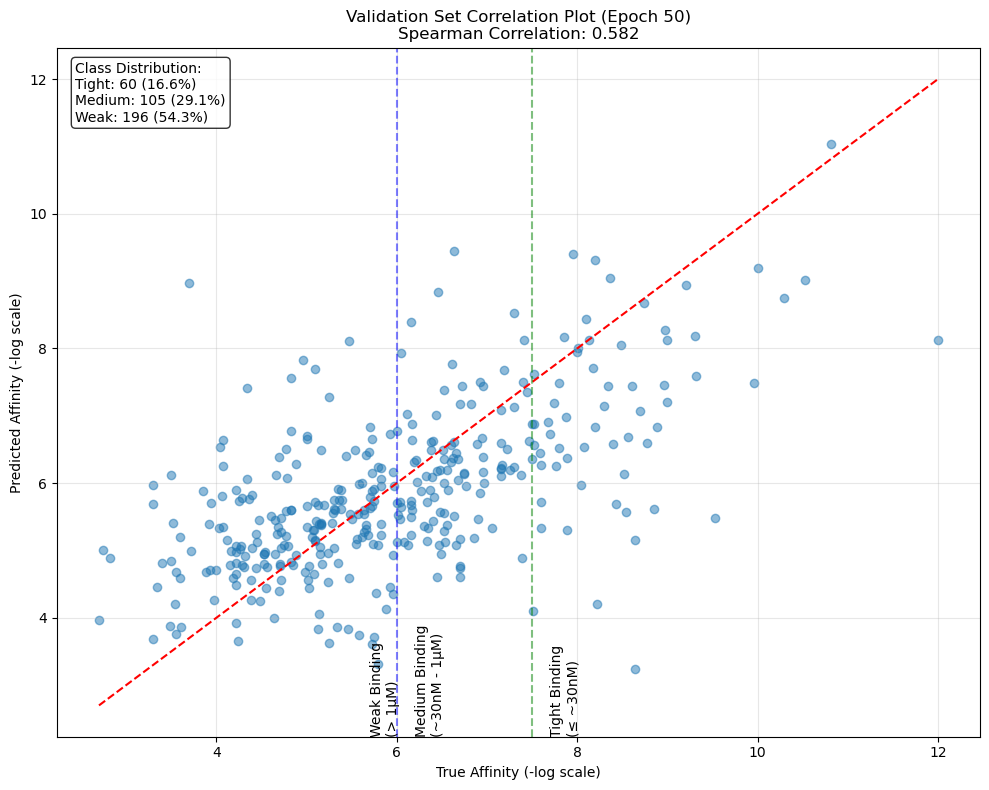

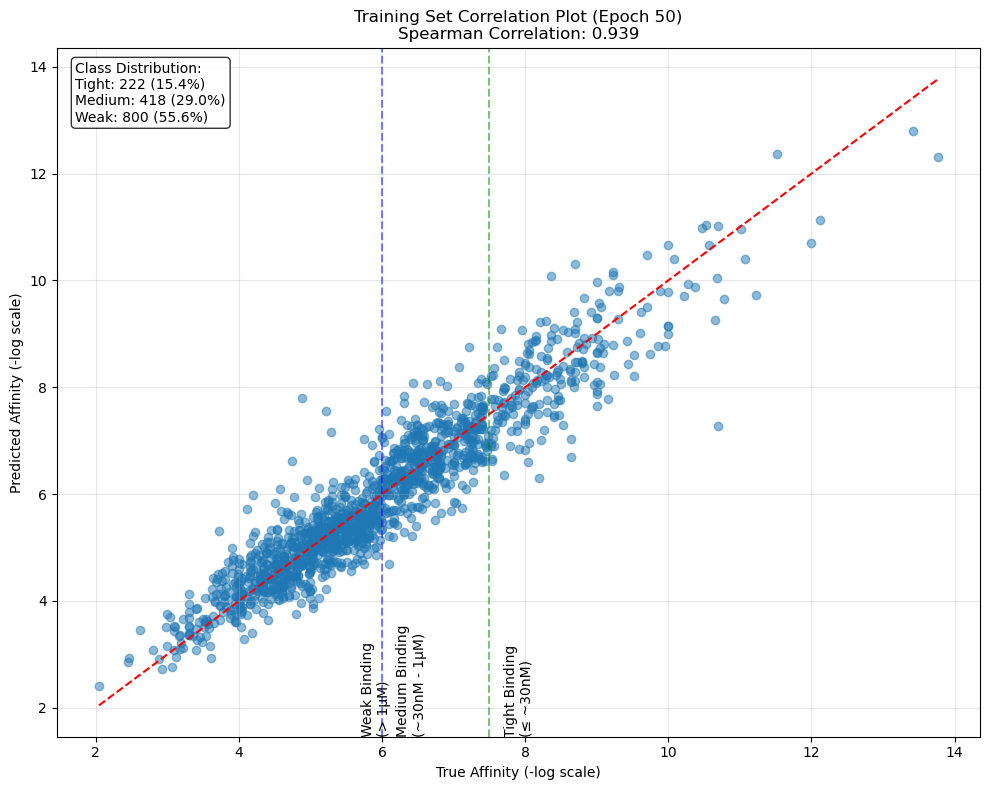


Training complete! Best model from epoch 21 with correlation: 0.6109
Model saved as: best_model.pt
Correlation plots saved as: best_model_val_correlation.png, best_model_train_correlation.png


In [27]:
model = ImprovedBindingPredictor(
    esm_dim=1280,
    smiles_dim=768,
    hidden_dim=512,
    n_heads=8,
    n_layers=3,
    dropout=0.1
).to(device)

criterion_reg = nn.MSELoss()
criterion_cls = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# Track best model
best_val_correlation = -1.0
best_epoch = 0
best_train_results = None
best_val_results = None

num_epochs = 50
for epoch in range(num_epochs):
    train_results = train_epoch(model, train_loader, optimizer, criterion_reg, criterion_cls, device)
    val_results = validate_epoch(model, val_loader, criterion_reg, criterion_cls, device)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train - Reg Loss: {train_results["reg_loss"]:.4f}, Cls Loss: {train_results["cls_loss"]:.4f}')
    print(f'Train - Correlation: {train_results["correlation"]:.4f}, Accuracy: {train_results["accuracy"]:.4f}')
    print('Train - Per-class F1:', train_results["per_class_f1"])
    print(f'Val - Reg Loss: {val_results["reg_loss"]:.4f}, Cls Loss: {val_results["cls_loss"]:.4f}')
    print(f'Val - Correlation: {val_results["correlation"]:.4f}, Accuracy: {val_results["accuracy"]:.4f}')
    print('Val - Per-class F1:', val_results["per_class_f1"])
    
    # Save best model based on validation correlation
    if val_results["correlation"] > best_val_correlation:
        best_val_correlation = val_results["correlation"]
        best_epoch = epoch + 1
        best_train_results = train_results
        best_val_results = val_results
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_correlation': val_results["correlation"],
            'val_accuracy': val_results["accuracy"],
            'val_f1': val_results["f1_score"],
            'train_correlation': train_results["correlation"],
        }, 'best_model.pt')
        print(f'✓ Saved best model at epoch {epoch+1} with validation correlation: {val_results["correlation"]:.4f}')
        
        # Save correlation plots for best model
        plt.figure(figsize=(10, 8))
        plt.scatter(val_results['true_values'], val_results['reg_predictions'], alpha=0.5)
        val_true = np.array(val_results['true_values'])
        val_pred = np.array(val_results['reg_predictions'])
        min_val = min(val_true.min(), val_pred.min())
        max_val = max(val_true.max(), val_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Correlation')
        plt.axvline(x=7.5, color='g', linestyle='--', alpha=0.5)
        plt.axvline(x=6.0, color='b', linestyle='--', alpha=0.5)
        plt.xlabel('True Affinity (-log scale)')
        plt.ylabel('Predicted Affinity (-log scale)')
        plt.title(f'Best Model Validation Set (Epoch {epoch+1})\nSpearman Correlation: {val_results["correlation"]:.3f}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('best_model_val_correlation.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        plt.figure(figsize=(10, 8))
        plt.scatter(train_results['true_values'], train_results['reg_predictions'], alpha=0.5)
        train_true = np.array(train_results['true_values'])
        train_pred = np.array(train_results['reg_predictions'])
        min_val = min(train_true.min(), train_pred.min())
        max_val = max(train_true.max(), train_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Correlation')
        plt.axvline(x=7.5, color='g', linestyle='--', alpha=0.5)
        plt.axvline(x=6.0, color='b', linestyle='--', alpha=0.5)
        plt.xlabel('True Affinity (-log scale)')
        plt.ylabel('Predicted Affinity (-log scale)')
        plt.title(f'Best Model Training Set (Epoch {epoch+1})\nSpearman Correlation: {train_results["correlation"]:.3f}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('best_model_train_correlation.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f'✓ Saved correlation plots: best_model_val_correlation.png, best_model_train_correlation.png')
    
    if epoch == num_epochs - 1:
        plot_correlation_with_classes(
            val_results['reg_predictions'], 
            val_results['true_values'],
            epoch + 1, 
            "Validation"
        )
        plot_correlation_with_classes(
            train_results['reg_predictions'], 
            train_results['true_values'],
            epoch + 1, 
            "Training"
        )

print(f'\nTraining complete! Best model from epoch {best_epoch} with correlation: {best_val_correlation:.4f}')
print(f'Model saved as: best_model.pt')
print(f'Correlation plots saved as: best_model_val_correlation.png, best_model_train_correlation.png')
